In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6
rcParams['font.size'] = 18.0
import warnings
warnings.filterwarnings("ignore")
import datetime 
import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init(nthreads=-1,min_mem_size=64)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /Users/bryceeb/anaconda/envs/python35/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/8w/f1tk_t090331dvv64myq_q_m0000gn/T/tmp6trfqnqr
  JVM stdout: /var/folders/8w/f1tk_t090331dvv64myq_q_m0000gn/T/tmp6trfqnqr/h2o_bryceeb_started_from_python.out
  JVM stderr: /var/folders/8w/f1tk_t090331dvv64myq_q_m0000gn/T/tmp6trfqnqr/h2o_bryceeb_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,5 months and 10 days !!!
H2O cluster name:,H2O_from_python_bryceeb_spet6k
H2O cluster total nodes:,1
H2O cluster free memory:,61.33 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [2]:
df = pd.read_csv('ev_premise_loads.csv')
df.columns

Index(['cont_acc', 'Installation', 'ev_funct_loc', 'contract', 'premise',
       'funct_loc', 'dvd_num', 'rate_cat', 'location_type',
       'servicepointidnum', 'servicepoint', 'sasdate', 'meter',
       'ChannelNumber', 'kwh_1', 'kwh_2', 'kwh_3', 'kwh_4', 'kwh_5', 'kwh_6',
       'kwh_7', 'kwh_8', 'kwh_9', 'kwh_10', 'kwh_11', 'kwh_12', 'kwh_13',
       'kwh_14', 'kwh_15', 'kwh_16', 'kwh_17', 'kwh_18', 'kwh_19', 'kwh_20',
       'kwh_21', 'kwh_22', 'kwh_23', 'kwh_24', 'kwh_day', 'mth', 'match'],
      dtype='object')

In [31]:
df.head()

,cont_acc,Installation,ev_funct_loc,contract,premise,funct_loc,dvd_num,rate_cat,location_type,servicepointidnum,...,kwh_19,kwh_20,kwh_21,kwh_22,kwh_23,kwh_24,kwh_day,mth,match,Date
0,116036,416049,2573644,390631,NaN,1100947,NaN,RSG,evmeter,2573644,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0,NaN,2011-05-20
1,116036,416049,2573644,390631,NaN,1100947,NaN,RSG,premise,1100947,...,2.9040,1.1712,0.4740,0.4452,0.5124,0.3516,31.1316,5.0,NaN,2011-05-20
2,116036,416049,2573644,390631,NaN,1100947,NaN,RSG,evmeter,2573644,...,0.0000,0.0000,3.1032,2.0904,0.0000,0.0000,5.1936,5.0,NaN,2011-05-21
3,116036,416049,2573644,390631,NaN,1100947,NaN,RSG,premise,1100947,...,0.9312,0.5844,3.6192,2.6760,0.5436,0.5844,31.7484,5.0,NaN,2011-05-21
4,116036,416049,2573644,390631,NaN,1100947,NaN,RSG,evmeter,2573644,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0,NaN,2011-05-22


In [3]:
len(df.servicepoint.unique())

78

In [4]:
df.match.unique() # 1 = has electric vehicle

array([ nan,   0.,   1.])

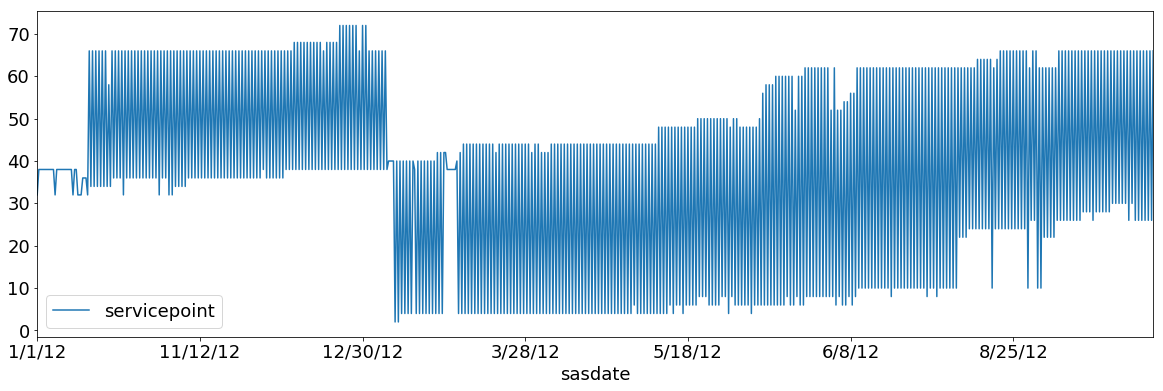

In [5]:
df.groupby(['sasdate'])[['servicepoint']].count().plot()

In [6]:
df['Date'] = pd.to_datetime(df['sasdate'])

In [7]:
ev = df.groupby('servicepoint').apply(lambda x: x.set_index('Date').resample('1D').first())[['kwh_1', 'kwh_2', 'kwh_3', 'kwh_4', 'kwh_5', 'kwh_6',
       'kwh_7', 'kwh_8', 'kwh_9', 'kwh_10', 'kwh_11', 'kwh_12', 'kwh_13',
       'kwh_14', 'kwh_15', 'kwh_16', 'kwh_17', 'kwh_18', 'kwh_19', 'kwh_20',
       'kwh_21', 'kwh_22', 'kwh_23', 'kwh_24', 'kwh_day']]

In [8]:
ev_avg = ev.groupby(level=0).apply(lambda x: x.shift().rolling(min_periods=1,window=90).mean()).reset_index()

In [9]:
ev_avg_most_recent = ev_avg.loc[ev_avg.groupby('servicepoint').Date.idxmax(),:]

In [32]:
ev_avg_most_recent .head()

,servicepoint,Date,kwh_1,kwh_2,kwh_3,kwh_4,kwh_5,kwh_6,kwh_7,kwh_8,...,kwh_16,kwh_17,kwh_18,kwh_19,kwh_20,kwh_21,kwh_22,kwh_23,kwh_24,kwh_day
7,1003963,2012-12-31,3.267943,3.356743,2.571086,2.318229,1.611943,1.337486,1.369886,1.399886,...,1.960457,2.090743,3.062743,4.143086,4.860343,3.040457,3.652286,4.151829,3.475029,64.982400
521,1006861,2012-12-31,1.108440,1.240973,0.741233,0.230160,0.184587,0.288253,0.347600,0.386400,...,0.266160,0.319200,0.401960,0.436667,0.402840,0.354493,0.290493,0.294067,0.196040,9.556807
1011,1009735,2012-12-31,3.862533,3.618467,3.232580,2.297053,1.033600,0.729173,0.769627,1.203227,...,1.771027,1.279173,1.302667,1.673560,1.801933,2.013600,1.909547,1.779920,1.588987,43.284673
1019,1046635,2012-12-31,2.705829,2.188114,1.821771,1.168629,1.283143,1.153029,2.083886,1.220571,...,1.085143,1.219371,1.314514,1.396114,1.367314,2.698114,3.584229,3.694800,3.049886,44.726400
1220,1086803,2012-12-31,0.524867,1.478347,2.709680,3.225960,2.687120,0.843227,0.753587,0.551160,...,0.947253,0.977480,1.208160,1.261227,1.218547,1.092640,0.910373,0.534893,0.384680,25.372853


In [10]:
has_ev = df.groupby(['servicepoint', 'match'])[['sasdate']].count().reset_index()
len(df.groupby(['servicepoint', 'match'])[['servicepoint']].count())

44

In [11]:
len(ev_avg_most_recent)

78

In [12]:
has_ev = has_ev[['servicepoint','match']]

In [13]:
has_ev = has_ev[has_ev.match == 1]

In [14]:
has_ev[:1]

,servicepoint,match
0,1006861,1.0


In [15]:
ev_avg_most_recent[:1]

,servicepoint,Date,kwh_1,kwh_2,kwh_3,kwh_4,kwh_5,kwh_6,kwh_7,kwh_8,...,kwh_16,kwh_17,kwh_18,kwh_19,kwh_20,kwh_21,kwh_22,kwh_23,kwh_24,kwh_day
7,1003963,2012-12-31,3.267943,3.356743,2.571086,2.318229,1.611943,1.337486,1.369886,1.399886,...,1.960457,2.090743,3.062743,4.143086,4.860343,3.040457,3.652286,4.151829,3.475029,64.9824


In [16]:
ev_pred_df = pd.merge(ev_avg_most_recent, has_ev, how = 'left', on ='servicepoint')

In [17]:
ev_pred_df = ev_pred_df.fillna(0)

In [18]:
ev_pred_df['overnight_avg'] = ev_pred_df[['kwh_23', 'kwh_24', 'kwh_1', 'kwh_2', 'kwh_3']].mean(axis=1)

In [19]:
ev_pred_df.columns

Index(['servicepoint', 'Date', 'kwh_1', 'kwh_2', 'kwh_3', 'kwh_4', 'kwh_5',
       'kwh_6', 'kwh_7', 'kwh_8', 'kwh_9', 'kwh_10', 'kwh_11', 'kwh_12',
       'kwh_13', 'kwh_14', 'kwh_15', 'kwh_16', 'kwh_17', 'kwh_18', 'kwh_19',
       'kwh_20', 'kwh_21', 'kwh_22', 'kwh_23', 'kwh_24', 'kwh_day', 'match',
       'overnight_avg'],
      dtype='object')

In [33]:
ev_pred_df.head()

,servicepoint,Date,kwh_1,kwh_2,kwh_3,kwh_4,kwh_5,kwh_6,kwh_7,kwh_8,...,kwh_18,kwh_19,kwh_20,kwh_21,kwh_22,kwh_23,kwh_24,kwh_day,match,overnight_avg
0,1003963,2012-12-31,3.267943,3.356743,2.571086,2.318229,1.611943,1.337486,1.369886,1.399886,...,3.062743,4.143086,4.860343,3.040457,3.652286,4.151829,3.475029,64.982400,0.0,3.364526
1,1006861,2012-12-31,1.108440,1.240973,0.741233,0.230160,0.184587,0.288253,0.347600,0.386400,...,0.401960,0.436667,0.402840,0.354493,0.290493,0.294067,0.196040,9.556807,1.0,0.716151
2,1009735,2012-12-31,3.862533,3.618467,3.232580,2.297053,1.033600,0.729173,0.769627,1.203227,...,1.302667,1.673560,1.801933,2.013600,1.909547,1.779920,1.588987,43.284673,1.0,2.816497
3,1046635,2012-12-31,2.705829,2.188114,1.821771,1.168629,1.283143,1.153029,2.083886,1.220571,...,1.314514,1.396114,1.367314,2.698114,3.584229,3.694800,3.049886,44.726400,0.0,2.692080
4,1086803,2012-12-31,0.524867,1.478347,2.709680,3.225960,2.687120,0.843227,0.753587,0.551160,...,1.208160,1.261227,1.218547,1.092640,0.910373,0.534893,0.384680,25.372853,0.0,1.126493


### Modeling

In [20]:
ev_df = h2o.H2OFrame(ev_pred_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
ev_df["kwh_23_c"]=ev_df["kwh_23"].ascharacter()
ev_df["kwh_24_c"]=ev_df["kwh_24"].ascharacter()
ev_df["kwh_1_c"]=ev_df["kwh_1"].ascharacter()
ev_df["kwh_2_c"]=ev_df["kwh_2"].ascharacter()
ev_df["kwh_3_c"]=ev_df["kwh_3"].ascharacter()

ev_df["kwh_23_c"]=ev_df["kwh_23_c"].asfactor()
ev_df["kwh_24_c"]=ev_df["kwh_24_c"].asfactor()
ev_df["kwh_1_c"]=ev_df["kwh_1_c"].asfactor()
ev_df["kwh_2_c"]=ev_df["kwh_2_c"].asfactor()
ev_df["kwh_3_c"]=ev_df["kwh_3_c"].asfactor()

ev_df["match"]=ev_df["match"].ascharacter()
ev_df["match"]=ev_df["match"].asfactor()

In [22]:
interaction_cols = ['kwh_23_c', 'kwh_24_c','kwh_1_c','kwh_2_c','kwh_3_c']

In [23]:
ev_df['overnight_charging'] = ev_df.interaction(factors=interaction_cols,
                                   pairwise=False,
                                   max_factors=100000,
                                   min_occurrence=1,
                                   destination_frame="itest")

Interactions progress: |██████████████████████████████████████████████████| 100%


In [24]:
ev_df.head()

servicepoint,Date,kwh_1,kwh_2,kwh_3,kwh_4,kwh_5,kwh_6,kwh_7,kwh_8,kwh_9,kwh_10,kwh_11,kwh_12,kwh_13,kwh_14,kwh_15,kwh_16,kwh_17,kwh_18,kwh_19,kwh_20,kwh_21,kwh_22,kwh_23,kwh_24,kwh_day,match,overnight_avg,kwh_23_c,kwh_24_c,kwh_1_c,kwh_2_c,kwh_3_c,overnight_charging
1.00396e+06,2012-12-31 00:00:00,3.26794,3.35674,2.57109,2.31823,1.61194,1.33749,1.36989,1.39989,1.71463,2.36434,2.76206,2.51194,2.95697,2.82686,2.17543,1.96046,2.09074,3.06274,4.14309,4.86034,3.04046,3.65229,4.15183,3.47503,64.9824,0,3.36453,4.1518,3.475,3.2679,3.3567,2.571,4.1518_3.475_3.2679_3.3567_2.571
1.00686e+06,2012-12-31 00:00:00,1.10844,1.24097,0.741233,0.23016,0.184587,0.288253,0.3476,0.3864,0.374987,0.370147,0.26104,0.265507,0.290253,0.239307,0.266,0.26616,0.3192,0.40196,0.436667,0.40284,0.354493,0.290493,0.294067,0.19604,9.55681,1,0.716151,0.294,0.196,1.1084,1.2409,0.7412,0.294_0.196_1.1084_1.2409_0.7412
1.00974e+06,2012-12-31 00:00:00,3.86253,3.61847,3.23258,2.29705,1.0336,0.729173,0.769627,1.20323,1.04995,1.14435,1.64841,1.81111,1.80825,2.02543,1.93051,1.77103,1.27917,1.30267,1.67356,1.80193,2.0136,1.90955,1.77992,1.58899,43.2847,1,2.8165,1.7799,1.5889,3.8625,3.6184,3.2325,1.7799_1.5889_3.8625_3.6184_3.2325
1.04664e+06,2012-12-31 00:00:00,2.70583,2.18811,1.82177,1.16863,1.28314,1.15303,2.08389,1.22057,1.40777,1.96594,1.51406,1.46846,1.59137,1.84646,1.89789,1.08514,1.21937,1.31451,1.39611,1.36731,2.69811,3.58423,3.6948,3.04989,44.7264,0,2.69208,3.6948,3.0498,2.7058,2.1881,1.8217,3.6948_3.0498_2.7058_2.1881_1.8217
1.0868e+06,2012-12-31 00:00:00,0.524867,1.47835,2.70968,3.22596,2.68712,0.843227,0.753587,0.55116,0.469907,0.41016,0.379707,0.497307,0.716747,0.790667,0.79916,0.947253,0.97748,1.20816,1.26123,1.21855,1.09264,0.910373,0.534893,0.38468,25.3729,0,1.12649,0.5348,0.3846,0.5248,1.4783,2.7096,0.5348_0.3846_0.5248_1.4783_2.7096
1.09198e+06,2012-12-31 00:00:00,0.965016,0.842022,0.716427,0.674589,0.769011,0.880692,1.10856,0.919564,0.891775,0.972607,1.04788,1.16976,1.3742,1.1788,1.25991,1.40558,1.62121,1.72549,1.73182,1.73732,2.7043,2.33265,2.07573,1.65071,31.7556,0,1.24998,2.0757,1.6507,0.965,0.842,0.7164,2.0757_1.6507_0.965_0.842_0.7164
1.10095e+06,2012-12-31 00:00:00,0.39524,0.39116,0.39222,0.359133,0.339947,0.45356,0.618053,0.944013,1.67413,1.76685,2.68899,2.51197,2.55413,2.53281,2.52337,2.24688,2.19995,1.63277,1.40951,1.07611,2.10429,1.80979,1.17151,0.556387,34.3528,1,0.581303,1.1715,0.5563,0.3952,0.3911,0.3922,1.1715_0.5563_0.3952_0.3911_0.3922
1.10195e+06,2012-12-31 00:00:00,1.66564,1.43455,0.88342,0.851693,0.849133,0.852587,0.888813,1.08596,0.94268,1.0058,1.00173,1.03772,1.24877,1.35967,1.54645,1.62663,1.48788,1.74241,1.89723,1.71745,3.39701,3.06124,2.12435,1.58583,35.2946,0,1.53876,2.1243,1.5858,1.6656,1.4345,0.8834,2.1243_1.5858_1.6656_1.4345_0.8834
1.11289e+06,2012-12-31 00:00:00,1.64631,1.68987,1.69824,1.69556,1.72875,1.87155,2.29276,2.72923,3.07809,2.6214,2.12129,1.82693,1.99867,2.24908,2.17109,1.93957,2.76491,2.61859,2.67792,2.42689,2.97311,2.86257,2.45192,1.97779,54.1121,1,1.89282,2.4519,1.9777,1.6463,1.6898,1.6982,2.4519_1.9777_1.6463_1.6898_1.6982
1.12077e+06,2012-12-31 00:00:00,1.00896,0.699093,0.670413,0.646853,0.68768,1.24731,1.81601,1.09829,1.03459,0.832933,0.907467,0.976707,0.895893,0.904933,0.854507,0.8464,1.14351,1.51679,1.62111,2.57149,5.09289,5.06245,4.07723,2.62161,38.8351,1,1.81546,4.0772,2.6216,1.0089,0.699,0.6704,4.0772_2.6216_1.0089_0.699_0.6704


In [25]:
def model_prep(df, train_ratio, test_ratio):
    train_R, test_R, rest_of_df_R = df.split_frame(ratios=[train_ratio, test_ratio])
    exclude_field = ['kwh_23_c', 'kwh_24_c','kwh_1_c','kwh_2_c','kwh_3_c', 'Date','servicepoint', 'kwh_day']
    target = ['match'] 
    features = [x for x in df.columns if x not in target and x not in exclude_field]
    return train_R, test_R, target, features

In [26]:
train, test, target, features = model_prep(ev_df, 0.80, 0.19)

In [27]:
trained_model = H2ORandomForestEstimator(model_id = 'trained_model'
                               ,balance_classes=True
                               ,binomial_double_trees=True
                               ,ntrees=15
                               ,seed=15)

trained_model.train(x=features, y=target[0], training_frame = train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [28]:
mod_performance = trained_model.model_performance(test_data=test)

In [29]:
mod_performance


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.14151793841931817
RMSE: 0.3761887005471033
LogLoss: 0.39937455264444244
Mean Per-Class Error: 0.09090909090909083
AUC: 0.9454545454545454
Gini: 0.8909090909090909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08457711442786069: 


,0,1,Error,Rate
0,9.0,2.0,0.1818,(2.0/11.0)
1,0.0,5.0,0.0,(0.0/5.0)
Total,9.0,7.0,0.125,(2.0/16.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0845771,0.8333333,2.0
max f2,0.0845771,0.9259259,2.0
max f0point5,0.425,0.8000000,1.0
max accuracy,0.425,0.875,1.0
max precision,0.5040431,1.0,0.0
max recall,0.0845771,1.0,2.0
max specificity,0.5040431,1.0,0.0
max absolute_mcc,0.0845771,0.7644708,2.0
max min_per_class_accuracy,0.0845771,0.8181818,2.0
max mean_per_class_accuracy,0.0845771,0.9090909,2.0


Gains/Lift Table: Avg response rate: 31.25 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0625,0.4921867,3.2,3.2,1.0,1.0,0.2,0.2,220.0000000,220.0000000
,2,0.0625,0.4803302,0.0,3.2,0.0,1.0,0.0,0.2,-100.0,220.0000000
,3,0.0625,0.4684737,0.0,3.2,0.0,1.0,0.0,0.2,-100.0,220.0000000
,4,0.0625,0.4566173,0.0,3.2,0.0,1.0,0.0,0.2,-100.0,220.0000000
,5,0.0625,0.4447608,0.0,3.2,0.0,1.0,0.0,0.2,-100.0,220.0000000
,6,0.3125,0.425,2.4,2.56,0.75,0.8,0.6,0.8,140.0,156.0
,7,0.3125,0.2547886,0.0,2.56,0.0,0.8,0.0,0.8,-100.0,156.0
,8,0.4375,0.0845771,1.6,2.2857143,0.5,0.7142857,0.2,1.0,60.0000000,128.5714286
,9,0.5,0.0128593,0.0,2.0,0.0,0.625,0.0,1.0,-100.0,100.0
,10,1.0,0.0,0.0,1.0,0.0,0.3125,0.0,1.0,-100.0,0.0


In [30]:
feature_importance = trained_model._model_json['output']['variable_importances'].as_data_frame()
feature_importance

,variable,relative_importance,scaled_importance,percentage
0,overnight_charging,200.252869,1.000000,0.360520
1,kwh_10,76.411110,0.381573,0.137565
2,kwh_8,47.711704,0.238257,0.085896
3,kwh_12,35.864647,0.179097,0.064568
4,kwh_22,23.178940,0.115748,0.041730
5,kwh_15,19.938337,0.099566,0.035895
6,kwh_11,19.214884,0.095953,0.034593
7,kwh_20,16.841957,0.084103,0.030321
8,kwh_9,16.141956,0.080608,0.029061
9,kwh_5,16.125332,0.080525,0.029031
